In [16]:
# %pip install -q causal-learn

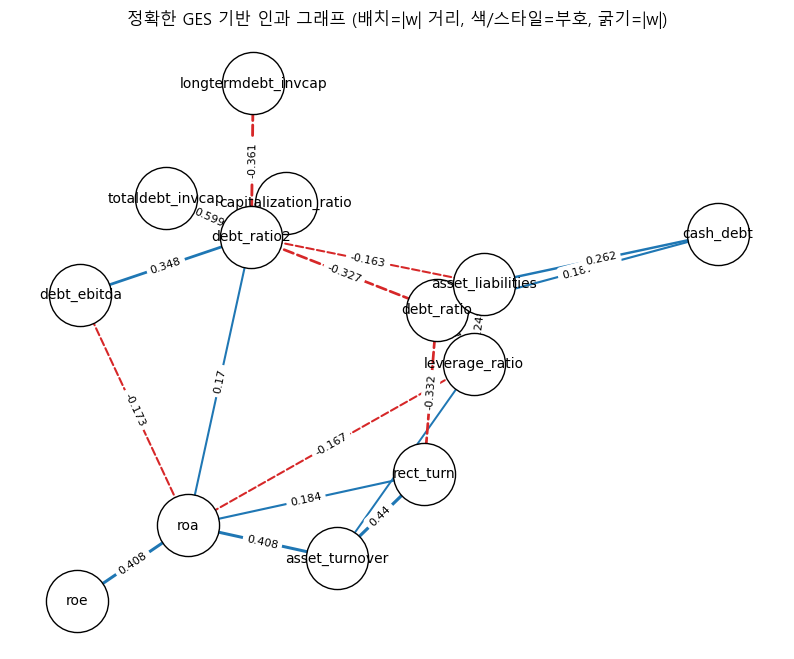

In [17]:
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.preprocessing import StandardScaler
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib

# causal-learn: 정확한 GES 구현
from causallearn.search.ScoreBased.GES import ges   # 기본 점수는 BIC
# from causallearn.score.LocalScoreFunction import local_score_BIC

# 한글 폰트/마이너스 설정(선택)
plt.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

# 0) 데이터 로드 (기존과 동일)
df = pd.read_csv("training_data.csv")
feature_cols = df.drop(columns=["Unnamed: 0", "label"]).columns
X_base = df[feature_cols].copy()
y = df["label"].astype(int)
cols_for_w = list(feature_cols)
cols = cols_for_w  # 시각화 라벨 호환

# 1) 정확한 GES 실행 (기본 BIC 점수 사용)
X_np = X_base.values.astype(float)
Record = ges(X_np)  # 또는 Record = ges(X_np, score_func='local_score_BIC')
Gmat = Record['G'].graph  # orientation 행렬 (numpy.ndarray)
# 문서: G.graph[j,i]=1 & G.graph[i,j]=-1 이면 i -> j (i가 부모, j가 자식)

# 2) 방향성 인접행렬 A (i <- j 형태로 저장하기 위해 A[child, parent]=1)
p = len(cols_for_w)
A = np.zeros((p, p), dtype=float)
for i in range(p):
    for j in range(p):
        if i == j:
            continue
        # i -> j ?
        if (Gmat[j, i] == 1) and (Gmat[i, j] == -1):
            A[j, i] = 1.0  # child=j, parent=i

# 3) 표준화 OLS로 엣지 가중치 행렬 W (i <- j)
Z = StandardScaler().fit_transform(X_np)
W = np.zeros_like(A, dtype=float)
for child in range(p):
    parents = np.where(A[child, :] == 1.0)[0]
    if parents.size == 0:
        continue
    y_child = Z[:, child]
    X_par = Z[:, parents]
    coef, *_ = np.linalg.lstsq(X_par, y_child, rcond=None)  # 절편 없음(표준화)
    W[child, parents] = coef.astype(float)

# ============ 여기부터 시각화 개선(음수 가중치 지원) ============

# 시각화 임계 설정
USE_QUANTILE = False      # 분위수 임계 사용 여부
W_THRESHOLD = 0.01        # 고정 임계(|W|>0.01)
W_ABS_QUANTILE = 0.90     # 상위 10%만 (USE_QUANTILE=True일 때 사용)

TOP_K_EDGES = 20        # 상위 |w| 간선만 표시하고 싶으면 정수(예: 100)로 설정

def get_threshold(W, fixed=W_THRESHOLD, use_q=USE_QUANTILE, q=W_ABS_QUANTILE):
    if not use_q:
        return fixed
    aw = np.abs(W).ravel()
    aw = aw[aw > 0]
    return float(np.quantile(aw, q)) if aw.size else fixed

thr = get_threshold(W)

# 4) 임계 적용 + (선택) 상위 K개 필터 → DiGraph 구성
edges_all = []
for i in range(p):
    for j in range(p):
        if i == j:
            continue
        w = float(W[i, j])
        if abs(w) > thr:
            edges_all.append((cols[j], cols[i], w))  # parent -> child, weight=w

# 상위 K개만 표시(선택)
if TOP_K_EDGES is not None and TOP_K_EDGES > 0 and len(edges_all) > TOP_K_EDGES:
    edges_all = sorted(edges_all, key=lambda t: abs(t[2]), reverse=True)[:TOP_K_EDGES]

G = nx.DiGraph()
for u, v, w in edges_all:
    G.add_edge(u, v, weight=round(w, 3))

# ---- 배치: 음수 가중치 문제 해결 (거리=1/(|w|+ε)로 양의 거리 그래프 H 구성)
eps = 1e-6
H = nx.Graph()  # 레이아웃 전용 보조 그래프(무향 + 양의 거리)
for u, v, d in G.edges(data=True):
    w = d.get("weight", 0.0)
    dist = 1.0 / (abs(w) + eps)   # |w| 클수록 더 가까워지도록
    H.add_edge(u, v, weight=dist)

pos = nx.kamada_kawai_layout(H, weight='weight')  # 안정적 배치

# ---- 스타일: 부호/크기 시각화
max_abs = max((abs(d["weight"]) for _, _, d in G.edges(data=True)), default=1.0)
pos_edges = [(u, v) for u, v, d in G.edges(data=True) if d["weight"] >= 0]
neg_edges = [(u, v) for u, v, d in G.edges(data=True) if d["weight"] < 0]
pos_widths = [1.0 + 3.0 * abs(G[u][v]["weight"]) / max_abs for u, v in pos_edges]
neg_widths = [1.0 + 3.0 * abs(G[u][v]["weight"]) / max_abs for u, v in neg_edges]

plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color="white", edgecolors="black")
nx.draw_networkx_labels(G, pos, font_size=10)

# 양수: 파란 실선 / 음수: 빨간 점선
nx.draw_networkx_edges(G, pos, edgelist=pos_edges, edge_color="tab:blue", width=pos_widths, arrows=True)
nx.draw_networkx_edges(G, pos, edgelist=neg_edges, edge_color="tab:red",  width=neg_widths, style="dashed", arrows=True)

# 원래 가중치 라벨(부호 유지)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'weight'), font_size=8)
plt.title("정확한 GES 기반 인과 그래프 (배치=|w| 거리, 색/스타일=부호, 굵기=|w|)")
plt.axis("off")
plt.show()


In [ ]:
# ============================================
# GES → Top-K(고정) → mul/mulw → LightGBM → O/F/OF
# (1) baseline:  GES edges + OLS W (Top-K 엣지 추출 → 고정)
# (2) randW:     baseline의 Top-K 엣지 쌍 그대로, W 가중치만 N(0,1)
# (3) randEdge:  엣지+가중치 무작위 (자체 W에서 Top-K 재추출)
# 저장: 각 실험별 Top-K 엣지 CSV + 리포트 CSV / 전체 통합 all_reports.csv
# 파일명 단순화: baseline_edges_top{K}.csv, baseline_report.csv, ...
# ============================================

# (필요시) pip:
# %pip install -q causallearn lightgbm

import os
import time
import numpy as np
import pandas as pd
from pathlib import Path
from typing import List, Dict, Tuple, Optional

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, brier_score_loss
from sklearn.preprocessing import StandardScaler

from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from causallearn.search.ScoreBased.GES import ges

# ---------------- 설정 ----------------
DATA_PATH       = "./training_data.csv"
LABEL_COL       = "label"
ID_PREFIX       = "Unnamed"  # 예: 'Unnamed: 0'

TOP_K_EDGES     = 20
N_SPLITS        = 10
RANDOM_STATE    = 42
PRINT_PROGRESS  = True

LGBM_PARAMS = dict(
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=63,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0,
    objective="binary",
    class_weight="balanced",
    random_state=RANDOM_STATE,
    n_jobs=-1
)
EARLY_STOPPING_ROUNDS = 50
# -------------------------------------


# =============== 유틸 ===============
def expected_calibration_error(y_true, y_prob, n_bins: int = 10) -> float:
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0
    total = len(y_true)
    for b in range(n_bins):
        left, right = bins[b], bins[b+1]
        mask = (y_prob >= left) & (y_prob < right) if b < n_bins-1 else (y_prob >= left) & (y_prob <= right)
        if not np.any(mask):
            continue
        acc = y_true[mask].mean()
        conf = y_prob[mask].mean()
        ece += (mask.sum() / total) * abs(acc - conf)
    return float(ece)


def run_cv_lgbm(X: pd.DataFrame, y: pd.Series,
                n_splits=10, random_state=42, tag: str = "") -> Dict[str, float]:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    f1s, auprcs, aurocs, briers, eces = [], [], [], [], []

    X_np = X.values.astype(np.float32)
    y_np = y.values.astype(int)

    for fold, (tr_idx, te_idx) in enumerate(skf.split(X_np, y_np), start=1):
        if PRINT_PROGRESS and tag:
            print(f"[{tag}] fold {fold}/{n_splits} ...", flush=True)

        X_tr, X_te = X_np[tr_idx], X_np[te_idx]
        y_tr, y_te = y_np[tr_idx], y_np[te_idx]

        X_tr_sub, X_val, y_tr_sub, y_val = train_test_split(
            X_tr, y_tr, test_size=0.2, random_state=random_state, stratify=y_tr
        )

        clf = LGBMClassifier(**LGBM_PARAMS)
        clf.fit(
            X_tr_sub, y_tr_sub,
            eval_set=[(X_val, y_val)],
            eval_metric="auc",
            callbacks=[
                early_stopping(EARLY_STOPPING_ROUNDS),
                log_evaluation(-1)
            ]
        )

        y_proba = clf.predict_proba(X_te)[:, 1]
        y_pred  = (y_proba >= 0.5).astype(int)

        f1s.append(f1_score(y_te, y_pred, zero_division=0))
        try:
            aurocs.append(roc_auc_score(y_te, y_proba))
        except Exception:
            aurocs.append(np.nan)
        try:
            auprcs.append(average_precision_score(y_te, y_proba))
        except Exception:
            auprcs.append(np.nan)
        briers.append(brier_score_loss(y_te, y_proba))
        eces.append(expected_calibration_error(y_te, y_proba, n_bins=10))

    return {
        "f1": float(np.nanmean(f1s)),
        "AUPRC": float(np.nanmean(auprcs)),
        "AUROC": float(np.nanmean(aurocs)),
        "Brier": float(np.nanmean(briers)),
        "ECE": float(np.nanmean(eces)),
    }


def ges_with_ols_weights(X_used: np.ndarray) -> np.ndarray:
    """GES로 방향 그래프 추정 후, 표준화 OLS로 W(i<-j) 계산."""
    Record = ges(X_used)  # 기본 BIC
    Gmat = Record['G'].graph  # 규칙: G.graph[j,i]=1 & G.graph[i,j]=-1 → i -> j

    p = X_used.shape[1]
    A = np.zeros((p, p), dtype=float)
    for i in range(p):
        for j in range(p):
            if i == j:
                continue
            if (Gmat[j, i] == 1) and (Gmat[i, j] == -1):  # i -> j
                A[j, i] = 1.0  # child=j, parent=i

    Z = StandardScaler().fit_transform(X_used)
    W = np.zeros_like(A, dtype=float)
    for child in range(p):
        parents = np.where(A[child, :] == 1.0)[0]
        if parents.size == 0:
            continue
        y_child = Z[:, child]
        X_par = Z[:, parents]
        coef, *_ = np.linalg.lstsq(X_par, y_child, rcond=None)  # 절편 없음(표준화 기준)
        W[child, parents] = coef.astype(float)
    return W


def edges_from_W(W: np.ndarray) -> List[Tuple[int, int]]:
    """W[i,j] : j -> i, 반환은 (u=parent=j, v=child=i)"""
    n = W.shape[0]
    ev = []
    nz = np.argwhere(np.abs(W) > 0)
    for i, j in nz:
        if i == j:
            continue
        ev.append((int(j), int(i)))
    return ev


def pick_top_k_edges(W: np.ndarray, top_k: int) -> List[Tuple[int, int, float]]:
    """(i<-j, w=W[i,j])의 |w| 상위 top_k → 리스트[(i, j, w)] (i:child, j:parent)"""
    n = W.shape[0]
    flat = []
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            w = W[i, j]
            if w == 0.0:
                continue
            flat.append((i, j, w))
    flat.sort(key=lambda t: (abs(t[2]), t[2]), reverse=True)
    return flat[:top_k]


def build_feature_df(X_base: pd.DataFrame, cols: List[str],
                     W: np.ndarray, feature_type: str, top_k: int,
                     fixed_pairs_ij: Optional[List[Tuple[int, int]]] = None) -> pd.DataFrame:
    """
    mul : A*B
    mulw: w_ij*(A*B)
    규약: w_ij = W[i,j], A=cols[j](parent), B=cols[i](child)
    fixed_pairs_ij가 주어지면 그 엣지 쌍(i,j)만 사용 (Top-K 재선정 없음)
    """
    if fixed_pairs_ij is None:
        pairs = [(i, j) for (i, j, _) in pick_top_k_edges(W, top_k=top_k)]
    else:
        pairs = list(fixed_pairs_ij)

    feats = {}
    for (i, j) in pairs:
        A_name = cols[j]; B_name = cols[i]
        if feature_type == "mul":
            name = f"{A_name}_mul_{B_name}"
            val = X_base[A_name] * X_base[B_name]
        elif feature_type == "mulw":
            name = f"{A_name}_mulw_{B_name}"
            val = W[i, j] * (X_base[A_name] * X_base[B_name])
        else:
            raise ValueError("feature_type must be 'mul' or 'mulw'")
        feats[name] = val.values
    return pd.DataFrame(feats, index=X_base.index)


def save_edges_to_csv(W: np.ndarray,
                      edges_uv: List[Tuple[int, int]],
                      X_df: pd.DataFrame,
                      csv_path: str,
                      weights: Optional[Dict[Tuple[int, int], float]] = None) -> pd.DataFrame:
    """|출발노드|가중치|도착노드| (컬럼명 사용)  edges_uv: (u=parent, v=child)"""
    cols = list(X_df.columns)
    for cand in ["label", "y", "target"]:
        if cand in cols:
            cols.remove(cand)
    N = W.shape[0]
    if len(cols) != N:
        raise ValueError(f"[save_edges_to_csv] 컬럼 수({len(cols)})와 W 크기({N}) 불일치.")

    rows = []
    for (u, v) in edges_uv:
        w = weights[(u, v)] if (weights is not None and (u, v) in weights) else float(W[v, u])
        rows.append({"출발노드": cols[u], "가중치": float(w), "도착노드": cols[v]})
    df_edges = pd.DataFrame(rows, columns=["출발노드", "가중치", "도착노드"])
    df_edges.to_csv(csv_path, index=False, encoding="utf-8-sig")
    print(f"[CSV] Saved edges → {csv_path} (rows={len(df_edges)})")
    return df_edges
# =============== /유틸 ===============


# 1) 데이터 로드
path = Path(DATA_PATH)
assert path.exists(), f"파일을 찾을 수 없습니다: {path}"
df = pd.read_csv(path)

assert LABEL_COL in df.columns, f"'{LABEL_COL}' 컬럼이 없습니다."
id_cols = [c for c in df.columns if c.startswith(ID_PREFIX)]
feature_cols = [c for c in df.columns if c not in id_cols + [LABEL_COL]]

X_base = df[feature_cols].copy()
y = df[LABEL_COL].astype(int).copy()

# 분산 0 피처 제외
var0_cols = [c for c in feature_cols if np.isclose(X_base[c].var(ddof=0), 0.0)]
cols_used = [c for c in feature_cols if c not in var0_cols]
X_used = X_base[cols_used].values.astype(float)
X_used_df = X_base[cols_used].copy()

# 출력 폴더 (타임스탬프 1단만)
outdir = Path(f"./runs_ges_lightgbm_20")
outdir.mkdir(parents=True, exist_ok=True)

# ===== baseline 먼저 실행하여 Top-K 엣지 "쌍(i,j)" 고정 =====
print("\n===== [baseline] 시작 =====")
W_baseline = ges_with_ols_weights(X_used)

# baseline Top-K 추출 (i=child, j=parent)
topk_triplets_baseline = pick_top_k_edges(W_baseline, top_k=TOP_K_EDGES)
baseline_topk_pairs_ij = [(i, j) for (i, j, w) in topk_triplets_baseline]

# CSV 저장 (parent,child 순서로 변환)
edges_uv_baseline = [(j, i) for (i, j) in baseline_topk_pairs_ij]
weights_baseline  = {(u, v): float(W_baseline[v, u]) for (u, v) in edges_uv_baseline}
csv_topk = outdir / f"baseline_edges_top{TOP_K_EDGES}.csv"
save_edges_to_csv(W_baseline, edges_uv_baseline, X_used_df, str(csv_topk), weights=weights_baseline)

# 파생 피처 생성(고정된 Top-K 기반)
Xf_m_baseline  = build_feature_df(X_used_df, cols_used, W_baseline, feature_type="mul",  top_k=TOP_K_EDGES, fixed_pairs_ij=baseline_topk_pairs_ij)
Xf_mw_baseline = build_feature_df(X_used_df, cols_used, W_baseline, feature_type="mulw", top_k=TOP_K_EDGES, fixed_pairs_ij=baseline_topk_pairs_ij)
Xf_mmw_baseline = pd.concat([Xf_m_baseline, Xf_mw_baseline], axis=1)

# 평가
res_O      = run_cv_lgbm(X_base, y, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag="baseline:O")
res_F_m    = run_cv_lgbm(Xf_m_baseline,  y, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag="baseline:F(m)")
res_OF_m   = run_cv_lgbm(pd.concat([X_base, Xf_m_baseline], axis=1),  y, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag="baseline:OF(m)")
res_F_mw   = run_cv_lgbm(Xf_mw_baseline, y, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag="baseline:F(mw)")
res_OF_mw  = run_cv_lgbm(pd.concat([X_base, Xf_mw_baseline], axis=1), y, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag="baseline:OF(mw)")
res_F_mmw  = run_cv_lgbm(Xf_mmw_baseline, y, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag="baseline:F(m+mw)")
res_OF_mmw = run_cv_lgbm(pd.concat([X_base, Xf_mmw_baseline], axis=1), y, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag="baseline:OF(m+mw)")

# 결과표 저장
col_top = ["O", "F", "OF"]
col_metrics = ["f1", "AUPRC", "AUROC", "Brier", "ECE"]
multi_cols = pd.MultiIndex.from_product([col_top, col_metrics])
index_rows = ["original", "m", "mw", "m+mw"]
report_baseline = pd.DataFrame(index=index_rows, columns=multi_cols, dtype=float)
for met in col_metrics:
    report_baseline.loc["original", ("O", met)] = res_O[met]
def _put(rep, row, res_F, res_OF):
    for met in col_metrics:
        rep.loc[row, ("O", met)]  = res_O[met]
        rep.loc[row, ("F", met)]  = res_F[met]
        rep.loc[row, ("OF", met)] = res_OF[met]
_put(report_baseline, "m",    res_F_m,   res_OF_m)
_put(report_baseline, "mw",   res_F_mw,  res_OF_mw)
_put(report_baseline, "m+mw", res_F_mmw, res_OF_mmw)
report_baseline = report_baseline.astype(float).round(4)
(report_baseline).to_csv(outdir / "baseline_report.csv", encoding="utf-8-sig")
print(f"[CSV] Saved report → {outdir/'baseline_report.csv'}")

# ===== randW: 같은 엣지, 가중치만 N(0,1) =====
print("\n===== [randW] 시작 =====")
rng = np.random.default_rng(RANDOM_STATE + 777)
W_randW = np.zeros_like(W_baseline)
# baseline의 비제로 위치 동일 + 가중치만 N(0,1)
nz = np.argwhere(np.abs(W_baseline) > 0)
for (i, j) in nz:
    if i == j:
        continue
    W_randW[i, j] = rng.normal(0.0, 1.0)

# CSV 저장(엣지는 baseline과 동일)
edges_uv_randW = edges_uv_baseline
weights_randW  = {(u, v): float(W_randW[v, u]) for (u, v) in edges_uv_randW}
csv_topk = outdir / f"randW_edges_top{TOP_K_EDGES}.csv"
save_edges_to_csv(W_randW, edges_uv_randW, X_used_df, str(csv_topk), weights=weights_randW)

# 파생 피처(고정 Top-K 쌍 사용)
Xf_m_randW  = build_feature_df(X_used_df, cols_used, W_randW, feature_type="mul",  top_k=TOP_K_EDGES, fixed_pairs_ij=baseline_topk_pairs_ij)
Xf_mw_randW = build_feature_df(X_used_df, cols_used, W_randW, feature_type="mulw", top_k=TOP_K_EDGES, fixed_pairs_ij=baseline_topk_pairs_ij)
Xf_mmw_randW = pd.concat([Xf_m_randW, Xf_mw_randW], axis=1)

# 평가
res_F_m    = run_cv_lgbm(Xf_m_randW,  y, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag="randW:F(m)")
res_OF_m   = run_cv_lgbm(pd.concat([X_base, Xf_m_randW], axis=1),  y, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag="randW:OF(m)")
res_F_mw   = run_cv_lgbm(Xf_mw_randW, y, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag="randW:F(mw)")
res_OF_mw  = run_cv_lgbm(pd.concat([X_base, Xf_mw_randW], axis=1), y, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag="randW:OF(mw)")
res_F_mmw  = run_cv_lgbm(Xf_mmw_randW, y, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag="randW:F(m+mw)")
res_OF_mmw = run_cv_lgbm(pd.concat([X_base, Xf_mmw_randW], axis=1), y, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag="randW:OF(m+mw)")

report_randW = pd.DataFrame(index=index_rows, columns=multi_cols, dtype=float)
for met in col_metrics:
    report_randW.loc["original", ("O", met)] = res_O[met]  # O는 baseline과 동일 입력 사용
_put(report_randW, "m",    res_F_m,   res_OF_m)
_put(report_randW, "mw",   res_F_mw,  res_OF_mw)
_put(report_randW, "m+mw", res_F_mmw, res_OF_mmw)
report_randW = report_randW.astype(float).round(4)
(report_randW).to_csv(outdir / "randW_report.csv", encoding="utf-8-sig")
print(f"[CSV] Saved report → {outdir/'randW_report.csv'}")

# ===== randEdge: 엣지+가중치 무작위 → 자체 Top-K 추출 =====
print("\n===== [randEdge] 시작 =====")
rng = np.random.default_rng(RANDOM_STATE + 999)
p = W_baseline.shape[0]
# baseline의 엣지 수 유지
K_edges = int(np.sum((np.abs(W_baseline) > 0) & (~np.eye(p, dtype=bool))))
cand = [(i, j) for i in range(p) for j in range(p) if i != j]
chosen_idx = rng.choice(len(cand), size=min(K_edges, len(cand)), replace=False)
W_randEdge = np.zeros_like(W_baseline)
for idx in chosen_idx:
    i, j = cand[idx]
    W_randEdge[i, j] = rng.normal(0.0, 1.0)

# randEdge의 Top-K는 randEdge W에서 새로 추출
topk_triplets_randEdge = pick_top_k_edges(W_randEdge, top_k=TOP_K_EDGES)
edges_uv_randEdge = [(j, i) for (i, j, w) in topk_triplets_randEdge]
weights_randEdge  = {(u, v): float(W_randEdge[v, u]) for (u, v) in edges_uv_randEdge}
csv_topk = outdir / f"randEdge_edges_top{TOP_K_EDGES}.csv"
save_edges_to_csv(W_randEdge, edges_uv_randEdge, X_used_df, str(csv_topk), weights=weights_randEdge)

# 파생 피처(자체 Top-K 사용)
randEdge_pairs_ij = [(i, j) for (i, j, w) in topk_triplets_randEdge]
Xf_m_randEdge  = build_feature_df(X_used_df, cols_used, W_randEdge, feature_type="mul",  top_k=TOP_K_EDGES, fixed_pairs_ij=randEdge_pairs_ij)
Xf_mw_randEdge = build_feature_df(X_used_df, cols_used, W_randEdge, feature_type="mulw", top_k=TOP_K_EDGES, fixed_pairs_ij=randEdge_pairs_ij)
Xf_mmw_randEdge = pd.concat([Xf_m_randEdge, Xf_mw_randEdge], axis=1)

# 평가
res_F_m    = run_cv_lgbm(Xf_m_randEdge,  y, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag="randEdge:F(m)")
res_OF_m   = run_cv_lgbm(pd.concat([X_base, Xf_m_randEdge], axis=1),  y, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag="randEdge:OF(m)")
res_F_mw   = run_cv_lgbm(Xf_mw_randEdge, y, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag="randEdge:F(mw)")
res_OF_mw  = run_cv_lgbm(pd.concat([X_base, Xf_mw_randEdge], axis=1), y, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag="randEdge:OF(mw)")
res_F_mmw  = run_cv_lgbm(Xf_mmw_randEdge, y, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag="randEdge:F(m+mw)")
res_OF_mmw = run_cv_lgbm(pd.concat([X_base, Xf_mmw_randEdge], axis=1), y, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag="randEdge:OF(m+mw)")

report_randEdge = pd.DataFrame(index=index_rows, columns=multi_cols, dtype=float)
for met in col_metrics:
    report_randEdge.loc["original", ("O", met)] = res_O[met]
_put(report_randEdge, "m",    res_F_m,   res_OF_m)
_put(report_randEdge, "mw",   res_F_mw,  res_OF_mw)
_put(report_randEdge, "m+mw", res_F_mmw, res_OF_mmw)
report_randEdge = report_randEdge.astype(float).round(4)
(report_randEdge).to_csv(outdir / "randEdge_report.csv", encoding="utf-8-sig")
print(f"[CSV] Saved report → {outdir/'randEdge_report.csv'}")

# 8) 세 실험 통합 리포트(평면 표)
def flatten_report(rep: pd.DataFrame, label: str) -> pd.DataFrame:
    col_top = ["O", "F", "OF"]
    col_metrics = ["f1", "AUPRC", "AUROC", "Brier", "ECE"]
    flat_rows = []
    for row in rep.index:
        for top in col_top:
            rec = {"exp": label, "row": row, "set": top}
            for met in col_metrics:
                rec[met] = rep.loc[row, (top, met)]
            flat_rows.append(rec)
    return pd.DataFrame(flat_rows)

combined = pd.concat([
    flatten_report(report_baseline, "baseline"),
    flatten_report(report_randW,   "randW"),
    flatten_report(report_randEdge,"randEdge")
], ignore_index=True)

combined_csv = outdir / "all_reports.csv"
combined.to_csv(combined_csv, index=False, encoding="utf-8-sig")
print(f"\n[CSV] Saved combined → {combined_csv}")
print(f"\n출력 폴더: {outdir.resolve()}")



===== [baseline] 시작 =====
[CSV] Saved edges → runs_ges_lightgbm\baseline_edges_top20.csv (rows=20)
[baseline:O] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3030
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	valid_0's auc: 0.928258	valid_0's binary_logloss: 0.286746
[baseline:O] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000634 seconds.
You can set `force_col_

c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[106]	valid_0's auc: 0.920933	valid_0's binary_logloss: 0.0914904
[baseline:O] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3025
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[82]	valid_0's auc: 0.953858	valid_0's binary_logloss: 0.105681
[baseline:O] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3034
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[70]	valid_0's auc: 0.928164	valid_0's binary_logloss: 0.121308
[baseline:O] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3032
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[130]	valid_0's auc: 0.939224	valid_0's binary_logloss: 0.0781649
[baseline:O] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3026
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[12]	valid_0's auc: 0.934356	valid_0's binary_logloss: 0.404145
[baseline:O] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3033
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[92]	valid_0's auc: 0.948507	valid_0's binary_logloss: 0.0898579
[baseline:O] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3029
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[39]	valid_0's auc: 0.925967	valid_0's binary_logloss: 0.198154
[baseline:O] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3025
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[148]	valid_0's auc: 0.924012	valid_0's binary_logloss: 0.080701
[baseline:O] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3033
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[64]	valid_0's auc: 0.927801	valid_0's binary_logloss: 0.132482
[baseline:F(m)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[95]	valid_0's auc: 0.929228	valid_0's binary_logloss: 0.0873921
[baseline:F(m)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[80]	valid_0's auc: 0.924504	valid_0's binary_logloss: 0.103749
[baseline:F(m)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[22]	valid_0's auc: 0.942062	valid_0's binary_logloss: 0.289179
[baseline:F(m)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[84]	valid_0's auc: 0.938472	valid_0's binary_logloss: 0.0982377
[baseline:F(m)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[24]	valid_0's auc: 0.926083	valid_0's binary_logloss: 0.266205
[baseline:F(m)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[178]	valid_0's auc: 0.924182	valid_0's binary_logloss: 0.0718631
[baseline:F(m)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[167]	valid_0's auc: 0.947778	valid_0's binary_logloss: 0.0645435
[baseline:F(m)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[24]	valid_0's auc: 0.929385	valid_0's binary_logloss: 0.269379
[baseline:F(m)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[46]	valid_0's auc: 0.925564	valid_0's binary_logloss: 0.154345
[baseline:F(m)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[14]	valid_0's auc: 0.91728	valid_0's binary_logloss: 0.37638
[baseline:OF(m)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8130
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[75]	valid_0's auc: 0.935711	valid_0's binary_logloss: 0.0964363
[baseline:OF(m)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8126
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[152]	valid_0's auc: 0.928562	valid_0's binary_logloss: 0.0754653
[baseline:OF(m)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8125
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[75]	valid_0's auc: 0.947192	valid_0's binary_logloss: 0.0949769
[baseline:OF(m)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8134
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[111]	valid_0's auc: 0.935286	valid_0's binary_logloss: 0.0756246
[baseline:OF(m)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8132
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[186]	valid_0's auc: 0.935206	valid_0's binary_logloss: 0.0719345
[baseline:OF(m)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8126
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[206]	valid_0's auc: 0.943863	valid_0's binary_logloss: 0.0632334
[baseline:OF(m)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8133
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[50]	valid_0's auc: 0.941322	valid_0's binary_logloss: 0.133169
[baseline:OF(m)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8129
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[78]	valid_0's auc: 0.940913	valid_0's binary_logloss: 0.0969991
[baseline:OF(m)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8125
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[62]	valid_0's auc: 0.93755	valid_0's binary_logloss: 0.109866
[baseline:OF(m)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8133
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[180]	valid_0's auc: 0.923282	valid_0's binary_logloss: 0.0767752
[baseline:F(mw)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[111]	valid_0's auc: 0.923139	valid_0's binary_logloss: 0.079881
[baseline:F(mw)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[96]	valid_0's auc: 0.924419	valid_0's binary_logloss: 0.0922109
[baseline:F(mw)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[9]	valid_0's auc: 0.936814	valid_0's binary_logloss: 0.45606
[baseline:F(mw)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[113]	valid_0's auc: 0.937591	valid_0's binary_logloss: 0.0792459
[baseline:F(mw)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[107]	valid_0's auc: 0.926812	valid_0's binary_logloss: 0.0889133
[baseline:F(mw)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[173]	valid_0's auc: 0.927296	valid_0's binary_logloss: 0.0701714
[baseline:F(mw)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[93]	valid_0's auc: 0.947138	valid_0's binary_logloss: 0.0834549
[baseline:F(mw)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[115]	valid_0's auc: 0.930687	valid_0's binary_logloss: 0.0804492
[baseline:F(mw)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[81]	valid_0's auc: 0.926848	valid_0's binary_logloss: 0.0971783
[baseline:F(mw)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[43]	valid_0's auc: 0.917392	valid_0's binary_logloss: 0.174309
[baseline:OF(mw)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8130
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[18]	valid_0's auc: 0.929501	valid_0's binary_logloss: 0.313236
[baseline:OF(mw)] fold 2/10 ...


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8126
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[177]	valid_0's auc: 0.930571	valid_0's binary_logloss: 0.0739777
[baseline:OF(mw)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8125
[LightGBM] [Info] Number of data points in the tr

c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[13]	valid_0's auc: 0.952512	valid_0's binary_logloss: 0.378703
[baseline:OF(mw)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8134
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[113]	valid_0's auc: 0.935711	valid_0's binary_logloss: 0.0761824
[baseline:OF(mw)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8132
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[159]	valid_0's auc: 0.939255	valid_0's binary_logloss: 0.0718595
[baseline:OF(mw)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8126
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[155]	valid_0's auc: 0.938638	valid_0's binary_logloss: 0.0648028
[baseline:OF(mw)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8133
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[113]	valid_0's auc: 0.944154	valid_0's binary_logloss: 0.0701407
[baseline:OF(mw)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8129
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[73]	valid_0's auc: 0.937698	valid_0's binary_logloss: 0.102062
[baseline:OF(mw)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8125
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[91]	valid_0's auc: 0.93755	valid_0's binary_logloss: 0.0863315
[baseline:OF(mw)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8133
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[35]	valid_0's auc: 0.92832	valid_0's binary_logloss: 0.190617
[baseline:F(m+mw)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[86]	valid_0's auc: 0.930846	valid_0's binary_logloss: 0.0921803
[baseline:F(m+mw)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[127]	valid_0's auc: 0.927179	valid_0's binary_logloss: 0.0797409
[baseline:F(m+mw)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[120]	valid_0's auc: 0.936284	valid_0's binary_logloss: 0.0716268
[baseline:F(m+mw)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[53]	valid_0's auc: 0.936696	valid_0's binary_logloss: 0.145018
[baseline:F(m+mw)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[64]	valid_0's auc: 0.921063	valid_0's binary_logloss: 0.124396
[baseline:F(m+mw)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[105]	valid_0's auc: 0.920468	valid_0's binary_logloss: 0.0871718
[baseline:F(m+mw)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[154]	valid_0's auc: 0.948217	valid_0's binary_logloss: 0.0658915
[baseline:F(m+mw)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[94]	valid_0's auc: 0.928262	valid_0's binary_logloss: 0.0912409
[baseline:F(m+mw)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[84]	valid_0's auc: 0.925291	valid_0's binary_logloss: 0.0951082
[baseline:F(m+mw)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[194]	valid_0's auc: 0.927837	valid_0's binary_logloss: 0.0749403
[baseline:OF(m+mw)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13230
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[64]	valid_0's auc: 0.941989	valid_0's binary_logloss: 0.108337
[baseline:OF(m+mw)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13226
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[134]	valid_0's auc: 0.921171	valid_0's binary_logloss: 0.0779099
[baseline:OF(m+mw)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13225
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[58]	valid_0's auc: 0.946897	valid_0's binary_logloss: 0.12411
[baseline:OF(m+mw)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13234
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[113]	valid_0's auc: 0.933877	valid_0's binary_logloss: 0.0752888
[baseline:OF(m+mw)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13232
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[177]	valid_0's auc: 0.942754	valid_0's binary_logloss: 0.0714481
[baseline:OF(m+mw)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13226
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[110]	valid_0's auc: 0.946436	valid_0's binary_logloss: 0.0726751
[baseline:OF(m+mw)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13233
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[9]	valid_0's auc: 0.938074	valid_0's binary_logloss: 0.437281
[baseline:OF(m+mw)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13229
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[57]	valid_0's auc: 0.932875	valid_0's binary_logloss: 0.123835
[baseline:OF(m+mw)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13225
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[138]	valid_0's auc: 0.94287	valid_0's binary_logloss: 0.0706399
[baseline:OF(m+mw)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13233
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[34]	valid_0's auc: 0.918822	valid_0's binary_logloss: 0.196221
[CSV] Saved report → runs_ges_lightgbm\baseline_report.csv

===== [randW] 시작 =====
[CSV] Saved edges → runs_ges_lightgbm\randW_edges_top20.csv (rows=20)
[randW:F(m)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001856 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[95]	valid_0's auc: 0.929228	valid_0's binary_logloss: 0.0873921
[randW:F(m)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[80]	valid_0's auc: 0.924504	valid_0's binary_logloss: 0.103749
[randW:F(m)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[22]	valid_0's auc: 0.942062	valid_0's binary_logloss: 0.289179
[randW:F(m)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[84]	valid_0's auc: 0.938472	valid_0's binary_logloss: 0.0982377
[randW:F(m)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[24]	valid_0's auc: 0.926083	valid_0's binary_logloss: 0.266205
[randW:F(m)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[178]	valid_0's auc: 0.924182	valid_0's binary_logloss: 0.0718631
[randW:F(m)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[167]	valid_0's auc: 0.947778	valid_0's binary_logloss: 0.0645435
[randW:F(m)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[24]	valid_0's auc: 0.929385	valid_0's binary_logloss: 0.269379
[randW:F(m)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[46]	valid_0's auc: 0.925564	valid_0's binary_logloss: 0.154345
[randW:F(m)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[14]	valid_0's auc: 0.91728	valid_0's binary_logloss: 0.37638
[randW:OF(m)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8130
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[75]	valid_0's auc: 0.935711	valid_0's binary_logloss: 0.0964363
[randW:OF(m)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8126
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[152]	valid_0's auc: 0.928562	valid_0's binary_logloss: 0.0754653
[randW:OF(m)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8125
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[75]	valid_0's auc: 0.947192	valid_0's binary_logloss: 0.0949769
[randW:OF(m)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8134
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[111]	valid_0's auc: 0.935286	valid_0's binary_logloss: 0.0756246
[randW:OF(m)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8132
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[186]	valid_0's auc: 0.935206	valid_0's binary_logloss: 0.0719345
[randW:OF(m)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8126
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[206]	valid_0's auc: 0.943863	valid_0's binary_logloss: 0.0632334
[randW:OF(m)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8133
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[50]	valid_0's auc: 0.941322	valid_0's binary_logloss: 0.133169
[randW:OF(m)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8129
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[78]	valid_0's auc: 0.940913	valid_0's binary_logloss: 0.0969991
[randW:OF(m)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8125
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[62]	valid_0's auc: 0.93755	valid_0's binary_logloss: 0.109866
[randW:OF(m)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8133
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[180]	valid_0's auc: 0.923282	valid_0's binary_logloss: 0.0767752
[randW:F(mw)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[126]	valid_0's auc: 0.929255	valid_0's binary_logloss: 0.0755769
[randW:F(mw)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[87]	valid_0's auc: 0.922611	valid_0's binary_logloss: 0.101577
[randW:F(mw)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[30]	valid_0's auc: 0.942221	valid_0's binary_logloss: 0.228914
[randW:F(mw)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[72]	valid_0's auc: 0.940821	valid_0's binary_logloss: 0.112971
[randW:F(mw)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[114]	valid_0's auc: 0.931649	valid_0's binary_logloss: 0.0854777
[randW:F(mw)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[212]	valid_0's auc: 0.924678	valid_0's binary_logloss: 0.0712916
[randW:F(mw)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[91]	valid_0's auc: 0.945698	valid_0's binary_logloss: 0.0821336
[randW:F(mw)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[88]	valid_0's auc: 0.930924	valid_0's binary_logloss: 0.0945887
[randW:F(mw)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[41]	valid_0's auc: 0.927707	valid_0's binary_logloss: 0.170289
[randW:F(mw)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[48]	valid_0's auc: 0.923685	valid_0's binary_logloss: 0.16042
[randW:OF(mw)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8130
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[73]	valid_0's auc: 0.938861	valid_0's binary_logloss: 0.0974601
[randW:OF(mw)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8126
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[179]	valid_0's auc: 0.92824	valid_0's binary_logloss: 0.0754011
[randW:OF(mw)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8125
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[124]	valid_0's auc: 0.949662	valid_0's binary_logloss: 0.0671025
[randW:OF(mw)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8134
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[112]	valid_0's auc: 0.933627	valid_0's binary_logloss: 0.0763831
[randW:OF(mw)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8132
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[149]	valid_0's auc: 0.936405	valid_0's binary_logloss: 0.0709206
[randW:OF(mw)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8126
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[177]	valid_0's auc: 0.939823	valid_0's binary_logloss: 0.0649473
[randW:OF(mw)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8133
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[105]	valid_0's auc: 0.945308	valid_0's binary_logloss: 0.0738441
[randW:OF(mw)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8129
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[16]	valid_0's auc: 0.935754	valid_0's binary_logloss: 0.343551
[randW:OF(mw)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8125
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[67]	valid_0's auc: 0.93896	valid_0's binary_logloss: 0.105121
[randW:OF(mw)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8133
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[179]	valid_0's auc: 0.922629	valid_0's binary_logloss: 0.0760274
[randW:F(m+mw)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[81]	valid_0's auc: 0.926311	valid_0's binary_logloss: 0.0981846
[randW:F(m+mw)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[180]	valid_0's auc: 0.925882	valid_0's binary_logloss: 0.0742459
[randW:F(m+mw)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[22]	valid_0's auc: 0.934864	valid_0's binary_logloss: 0.2869
[randW:F(m+mw)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[95]	valid_0's auc: 0.933309	valid_0's binary_logloss: 0.0902967
[randW:F(m+mw)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001994 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[64]	valid_0's auc: 0.921383	valid_0's binary_logloss: 0.123147
[randW:F(m+mw)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[121]	valid_0's auc: 0.925072	valid_0's binary_logloss: 0.0800264
[randW:F(m+mw)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[139]	valid_0's auc: 0.950579	valid_0's binary_logloss: 0.0649945
[randW:F(m+mw)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[134]	valid_0's auc: 0.930235	valid_0's binary_logloss: 0.0780918
[randW:F(m+mw)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[67]	valid_0's auc: 0.925537	valid_0's binary_logloss: 0.111531
[randW:F(m+mw)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[209]	valid_0's auc: 0.92641	valid_0's binary_logloss: 0.0757221
[randW:OF(m+mw)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13230
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[67]	valid_0's auc: 0.942141	valid_0's binary_logloss: 0.104685
[randW:OF(m+mw)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13226
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[183]	valid_0's auc: 0.923828	valid_0's binary_logloss: 0.0760184
[randW:OF(m+mw)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13225
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[72]	valid_0's auc: 0.951599	valid_0's binary_logloss: 0.0993203
[randW:OF(m+mw)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13234
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[110]	valid_0's auc: 0.935237	valid_0's binary_logloss: 0.0783422
[randW:OF(m+mw)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13232
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[165]	valid_0's auc: 0.934571	valid_0's binary_logloss: 0.0728594
[randW:OF(m+mw)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13226
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[167]	valid_0's auc: 0.937143	valid_0's binary_logloss: 0.0661617
[randW:OF(m+mw)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13233
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[18]	valid_0's auc: 0.935468	valid_0's binary_logloss: 0.305821
[randW:OF(m+mw)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13229
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[69]	valid_0's auc: 0.931318	valid_0's binary_logloss: 0.106439
[randW:OF(m+mw)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13225
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[116]	valid_0's auc: 0.93798	valid_0's binary_logloss: 0.0751539
[randW:OF(m+mw)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13233
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[23]	valid_0's auc: 0.916377	valid_0's binary_logloss: 0.26778
[CSV] Saved report → runs_ges_lightgbm\randW_report.csv

===== [randEdge] 시작 =====
[CSV] Saved edges → runs_ges_lightgbm\randEdge_edges_top20.csv (rows=20)
[randEdge:F(m)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001003 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[86]	valid_0's auc: 0.918795	valid_0's binary_logloss: 0.111899
[randEdge:F(m)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[183]	valid_0's auc: 0.909735	valid_0's binary_logloss: 0.0851637
[randEdge:F(m)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[116]	valid_0's auc: 0.934969	valid_0's binary_logloss: 0.0891698
[randEdge:F(m)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[47]	valid_0's auc: 0.904028	valid_0's binary_logloss: 0.184857
[randEdge:F(m)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[26]	valid_0's auc: 0.883302	valid_0's binary_logloss: 0.273892
[randEdge:F(m)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[84]	valid_0's auc: 0.915878	valid_0's binary_logloss: 0.110894
[randEdge:F(m)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[151]	valid_0's auc: 0.947917	valid_0's binary_logloss: 0.0737594
[randEdge:F(m)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[57]	valid_0's auc: 0.918473	valid_0's binary_logloss: 0.156519
[randEdge:F(m)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[138]	valid_0's auc: 0.916204	valid_0's binary_logloss: 0.0882614
[randEdge:F(m)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[78]	valid_0's auc: 0.905041	valid_0's binary_logloss: 0.124513
[randEdge:OF(m)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8130
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[37]	valid_0's auc: 0.923757	valid_0's binary_logloss: 0.183409
[randEdge:OF(m)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8126
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[151]	valid_0's auc: 0.921135	valid_0's binary_logloss: 0.0777829
[randEdge:OF(m)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8125
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[89]	valid_0's auc: 0.951093	valid_0's binary_logloss: 0.0868965
[randEdge:OF(m)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8134
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[90]	valid_0's auc: 0.931627	valid_0's binary_logloss: 0.0959226
[randEdge:OF(m)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8132
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[65]	valid_0's auc: 0.927779	valid_0's binary_logloss: 0.112859
[randEdge:OF(m)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8126
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[92]	valid_0's auc: 0.936378	valid_0's binary_logloss: 0.0839416
[randEdge:OF(m)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8133
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[130]	valid_0's auc: 0.944673	valid_0's binary_logloss: 0.069327
[randEdge:OF(m)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8129
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[112]	valid_0's auc: 0.924289	valid_0's binary_logloss: 0.0850073
[randEdge:OF(m)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8125
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[117]	valid_0's auc: 0.92449	valid_0's binary_logloss: 0.0792789
[randEdge:OF(m)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8133
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[42]	valid_0's auc: 0.923367	valid_0's binary_logloss: 0.169677
[randEdge:F(mw)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[80]	valid_0's auc: 0.925461	valid_0's binary_logloss: 0.117324
[randEdge:F(mw)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[214]	valid_0's auc: 0.899968	valid_0's binary_logloss: 0.085745
[randEdge:F(mw)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[228]	valid_0's auc: 0.931734	valid_0's binary_logloss: 0.0680811
[randEdge:F(mw)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[74]	valid_0's auc: 0.907162	valid_0's binary_logloss: 0.129407
[randEdge:F(mw)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[153]	valid_0's auc: 0.89672	valid_0's binary_logloss: 0.0886317
[randEdge:F(mw)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[89]	valid_0's auc: 0.920303	valid_0's binary_logloss: 0.105153
[randEdge:F(mw)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[159]	valid_0's auc: 0.945219	valid_0's binary_logloss: 0.0729746
[randEdge:F(mw)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[91]	valid_0's auc: 0.914688	valid_0's binary_logloss: 0.10937
[randEdge:F(mw)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[103]	valid_0's auc: 0.915654	valid_0's binary_logloss: 0.0994116
[randEdge:F(mw)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[65]	valid_0's auc: 0.905337	valid_0's binary_logloss: 0.141647
[randEdge:OF(mw)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8130
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[23]	valid_0's auc: 0.928886	valid_0's binary_logloss: 0.26806
[randEdge:OF(mw)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8126
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[174]	valid_0's auc: 0.919967	valid_0's binary_logloss: 0.0768008
[randEdge:OF(mw)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8125
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[130]	valid_0's auc: 0.95397	valid_0's binary_logloss: 0.0645887
[randEdge:OF(mw)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8134
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[74]	valid_0's auc: 0.928311	valid_0's binary_logloss: 0.10956
[randEdge:OF(mw)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8132
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[43]	valid_0's auc: 0.929841	valid_0's binary_logloss: 0.158406
[randEdge:OF(mw)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8126
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[101]	valid_0's auc: 0.932982	valid_0's binary_logloss: 0.0791016
[randEdge:OF(mw)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8133
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[110]	valid_0's auc: 0.944275	valid_0's binary_logloss: 0.0742268
[randEdge:OF(mw)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8129
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[5]	valid_0's auc: 0.922531	valid_0's binary_logloss: 0.535553
[randEdge:OF(mw)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8125
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[161]	valid_0's auc: 0.92645	valid_0's binary_logloss: 0.0741583
[randEdge:OF(mw)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8133
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[4]	valid_0's auc: 0.926526	valid_0's binary_logloss: 0.559907
[randEdge:F(m+mw)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[84]	valid_0's auc: 0.921332	valid_0's binary_logloss: 0.112483
[randEdge:F(m+mw)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[105]	valid_0's auc: 0.905695	valid_0's binary_logloss: 0.104934
[randEdge:F(m+mw)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[215]	valid_0's auc: 0.937546	valid_0's binary_logloss: 0.0696657
[randEdge:F(m+mw)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[110]	valid_0's auc: 0.907108	valid_0's binary_logloss: 0.099611
[randEdge:F(m+mw)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[159]	valid_0's auc: 0.892442	valid_0's binary_logloss: 0.087943
[randEdge:F(m+mw)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[86]	valid_0's auc: 0.917332	valid_0's binary_logloss: 0.10822
[randEdge:F(m+mw)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[128]	valid_0's auc: 0.944042	valid_0's binary_logloss: 0.0790114
[randEdge:F(m+mw)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[91]	valid_0's auc: 0.920213	valid_0's binary_logloss: 0.10863
[randEdge:F(m+mw)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[139]	valid_0's auc: 0.912562	valid_0's binary_logloss: 0.0883478
[randEdge:F(m+mw)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[65]	valid_0's auc: 0.906287	valid_0's binary_logloss: 0.140147
[randEdge:OF(m+mw)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13230
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[26]	valid_0's auc: 0.926475	valid_0's binary_logloss: 0.245487
[randEdge:OF(m+mw)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13226
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[159]	valid_0's auc: 0.923654	valid_0's binary_logloss: 0.0784702
[randEdge:OF(m+mw)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13225
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[20]	valid_0's auc: 0.9508	valid_0's binary_logloss: 0.304023
[randEdge:OF(m+mw)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13234
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[79]	valid_0's auc: 0.927179	valid_0's binary_logloss: 0.102469
[randEdge:OF(m+mw)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13232
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[137]	valid_0's auc: 0.932642	valid_0's binary_logloss: 0.0740179
[randEdge:OF(m+mw)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13226
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[125]	valid_0's auc: 0.938011	valid_0's binary_logloss: 0.0694415
[randEdge:OF(m+mw)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13233
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[85]	valid_0's auc: 0.947711	valid_0's binary_logloss: 0.0842813
[randEdge:OF(m+mw)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13229
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[1]	valid_0's auc: 0.906299	valid_0's binary_logloss: 0.656295
[randEdge:OF(m+mw)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13225
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[22]	valid_0's auc: 0.921003	valid_0's binary_logloss: 0.276396
[randEdge:OF(m+mw)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13233
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[27]	valid_0's auc: 0.930953	valid_0's binary_logloss: 0.240155
[CSV] Saved report → runs_ges_lightgbm\randEdge_report.csv

[CSV] Saved combined → runs_ges_lightgbm\all_reports.csv

출력 폴더: D:\University\3-2\PADALab\bank_failure_prediction_2\practice\Bank_Failure_Prediction_2\FromGPT\runs_ges_lightgbm


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
